# Hum Engagement Time Machine
## Final Model Using k-Means Clustered Labels and MLP-Based Classification

### Data Processing

In [1]:
# load in data file from local device
from google.colab import files
uploaded = files.upload()

Saving reached_16_all.csv to reached_16_all.csv


In [2]:
# import relevant packages
import pandas as pd
import numpy as np
import io

# read in uploaded csv data to a pandas dataframe
df = pd.read_csv(io.BytesIO(uploaded['reached_16_all.csv']))
df.sort_values(by = 'PROFILE_ID', inplace= True)
df

,Unnamed: 0,PROFILE_ID,REACHED_16_EVENTS,RECENT_LAST_EVENT,EVENT_CYCLES_ALL,DISTINCT_ARTICLES_ALL,PERCENT_GOOGLE_ARTICLES_ALL,PERCENT_ARTICLE_CONTENT_ALL,AVERAGE_CONTENT_SCORE_ALL,DAYS_TO_16_EVENTS,EVENTS,FIRST_EVENT_TIME,LATEST_EVENT_TIME,DISTINCT_DAYS
6,6,--0p74IB28LFeUkXSg6b,1,0,2,2,0.000000,1.000000,0.000000,133.0,16,2022-08-30 14:30:38.171966,2023-01-10 16:43:55.720219,2
13,13,--6dYIIB8Tq1gs32cnxN,1,0,1,1,1.000000,1.000000,0.000000,7.0,16,2022-08-02 22:11:48.120981,2022-08-09 16:19:25.990118,4
16,16,--7CGYYBRkWobPtw2Qjb,1,1,4,1,1.000000,1.000000,0.000000,27.0,24,2023-02-04 00:10:45.911994,2023-03-17 20:28:24.300215,5
18,18,--7egIIBGoM3uBpFKICG,1,0,11,11,1.000000,0.916667,1371.460317,5.0,63,2022-08-09 04:30:20.132357,2023-01-04 17:26:37.806226,15
26,26,--7xtoIBGoM3uBpFf0FV,1,0,3,2,0.000000,1.000000,0.000000,103.0,16,2022-08-19 16:30:57.064488,2022-11-30 19:41:43.155668,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138486,2293586,zzlKjIIBGoM3uBpFBagQ,1,1,6,5,0.800000,1.000000,0.000000,133.0,40,2022-08-11 09:43:58.953482,2023-03-25 12:01:41.668617,7
138245,2293345,zzpjDYQBEEdskq5qGMuW,1,0,5,1,0.000000,1.000000,0.000000,17.0,28,2022-10-25 04:25:09.614383,2023-02-11 00:25:21.186098,12
138016,2293116,zzrPDIQBEEdskq5qZRER,1,0,4,3,0.333333,1.000000,0.000000,129.0,16,2022-10-25 01:43:50.150416,2023-03-03 07:59:42.533219,4
137291,2292391,zzsQPYQBwWEOklUHCNVJ,1,0,1,0,0.000000,0.000000,0.000000,2.0,56,2022-11-03 10:36:12.009305,2022-11-08 11:59:11.293372,6


In [4]:
# remove outliers with greater than or equal to 100 events
df = df[df['EVENTS'] <= 100]

import datetime

# create potentially useful time-based features
# time till end
df['TTE'] = (pd.to_datetime(df['LATEST_EVENT_TIME'])-pd.to_datetime(df['FIRST_EVENT_TIME'])).dt.total_seconds() / (24 * 60 * 60)
# time till now
df['TTN'] = (datetime.datetime.now()-pd.to_datetime(df['FIRST_EVENT_TIME'])).dt.total_seconds() / (24 * 60 * 60)

# events per cycle
df['EpC'] = df['EVENTS']/df['EVENT_CYCLES_ALL']
# articles per event
df['ApE'] = df['DISTINCT_ARTICLES_ALL']/df['EVENTS']

# total events per day
df['tEpD'] = df['EVENTS']/df['TTN']
# active events per day
df['aEpD'] = df['EVENTS']/df['TTE']
# active ratio
df['aR'] = df['TTE']/df['TTN']

# event density
df['ED'] = df['EVENTS']/df['DISTINCT_DAYS']

# extract relevant columns of the data and their corresponding labels
data = df[['EpC','ApE','PERCENT_GOOGLE_ARTICLES_ALL','PERCENT_ARTICLE_CONTENT_ALL','ED']]
features = data.columns
data

,EpC,ApE,PERCENT_GOOGLE_ARTICLES_ALL,PERCENT_ARTICLE_CONTENT_ALL,ED
6,8.000000,0.125000,0.000000,1.000000,8.000000
13,16.000000,0.062500,1.000000,1.000000,4.000000
16,6.000000,0.041667,1.000000,1.000000,4.800000
18,5.727273,0.174603,1.000000,0.916667,4.200000
26,5.333333,0.125000,0.000000,1.000000,4.000000
...,...,...,...,...,...
138486,6.666667,0.125000,0.800000,1.000000,5.714286
138245,5.600000,0.035714,0.000000,1.000000,2.333333
138016,4.000000,0.187500,0.333333,1.000000,4.000000
137291,56.000000,0.000000,0.000000,0.000000,9.333333


In [5]:
from sklearn.preprocessing import StandardScaler

# define standard scaler
scaler = StandardScaler()
  
# transform data
data = scaler.fit_transform(data)

data

array([[-0.46297772, -0.03698767, -0.82938483,  0.60325245, -0.00709135],
       [ 0.28020412, -0.77451504,  1.81838572,  0.60325245, -0.58553197],
       [-0.64877318, -1.0203575 ,  1.81838572,  0.60325245, -0.46984385],
       ...,
       [-0.83456864,  0.7005397 ,  0.05320447,  0.60325245, -0.58553197],
       [ 3.99611333, -1.51204241, -0.82938483, -2.82118284,  0.18572219],
       [-0.66566368, -1.14327873,  0.49450045,  0.60325245, -0.5028976 ]])

### Generate Training Labels

In [7]:
from sklearn.cluster import KMeans

# perform clustering to get training labels
k = 2
KM = KMeans(n_clusters = 2, max_iter = 500, random_state = 82113)
KM.fit(data)
labels = KM.labels_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
# proportion of labels that are 1
sum(labels)/len(labels)

0.2291698147420593

1.024182710643281
-0.3044921781074258

-0.7062792247490755
0.2099786466428386

-0.5979952951527421
0.17778555332640328

-1.213602541575888
0.36080718547674917

0.9478137142769061
-0.28178747727443637



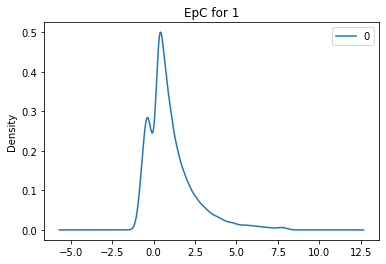

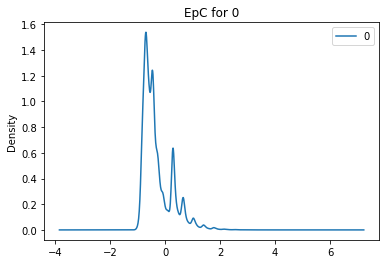

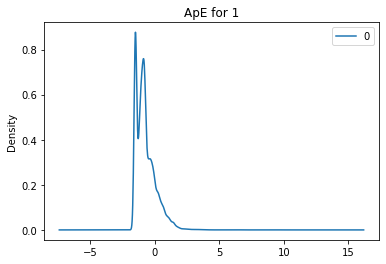

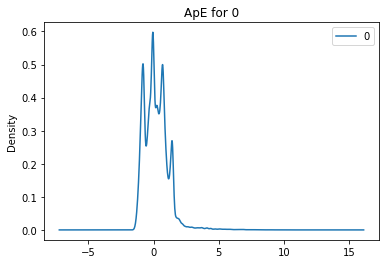

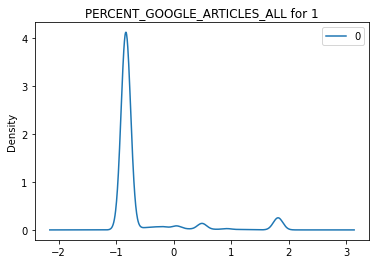

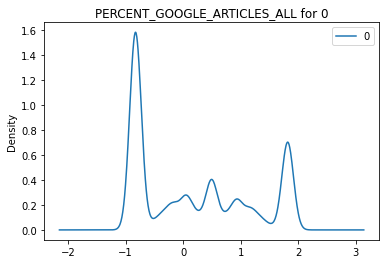

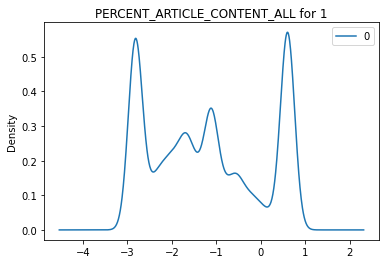

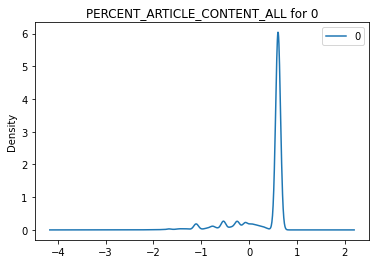

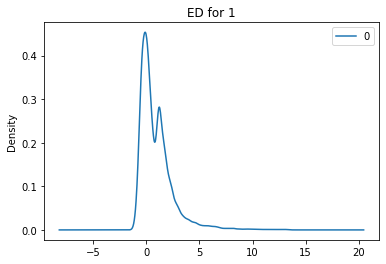

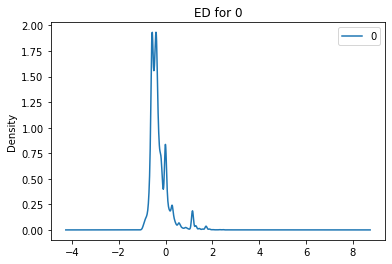

In [9]:
# loop through each feature
for i in range(data.shape[1]):
  # plot the class conditional density
  pd.DataFrame(data[labels == 1,i]).plot.kde(title = f'{features[i]} for 1')
  pd.DataFrame(data[labels == 0,i]).plot.kde(title = f'{features[i]} for 0')
  # print the class conditional mean
  print(data[labels == 1,i].mean())
  print(data[labels == 0,i].mean())
  print()

In [15]:
from google.colab import files

# export training labels
training_labels = pd.DataFrame({'labels': labels})
training_labels.to_csv('training_labels.csv', index=False)#encoding = 'utf-8-sig') 
files.download('training_labels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### MLP for Binary Classification (First 16 Events)

In [16]:
# load in data file from local device
from google.colab import files
uploaded = files.upload()

# also import training labels here if desired

Saving reached_16_first_16.csv to reached_16_first_16.csv


In [17]:
# import relevant packages
import pandas as pd
import numpy as np
import io

# read in uploaded csv data to a pandas dataframe
df = pd.read_csv(io.BytesIO(uploaded['reached_16_first_16.csv']))
df.sort_values(by = 'PROFILE_ID', inplace = True)
df

,Unnamed: 0,PROFILE_ID,REACHED_16_EVENTS,REACHED_80_EVENTS,RECENT_LAST_EVENT,EVENT_CYCLES_F16,DISTINCT_ARTICLES_F16,PERCENT_GOOGLE_ARTICLES_F16,PERCENT_ARTICLE_CONTENT_F16,AVERAGE_CONTENT_SCORE_F16,DAYS_TO_16_EVENTS,EVENTS,FIRST_EVENT_TIME,EVENT_TIME_16,DISTINCT_DAYS_F16
11,11,--0p74IB28LFeUkXSg6b,1,0,0,2,2,0.000000,1.0,0.0,133.0,16,2022-08-30 14:30:38.171966,2023-01-10 16:43:55.720219,2
29,29,--6dYIIB8Tq1gs32cnxN,1,0,0,1,1,1.000000,1.0,0.0,7.0,16,2022-08-02 22:11:48.120981,2022-08-09 16:19:25.990118,4
2,2,--7CGYYBRkWobPtw2Qjb,1,0,1,3,1,1.000000,1.0,0.0,27.0,24,2023-02-04 00:10:45.911994,2023-03-03 04:29:56.373198,3
7,7,--7egIIBGoM3uBpFKICG,1,0,0,1,4,1.000000,1.0,0.0,5.0,63,2022-08-09 04:30:20.132357,2022-08-14 21:53:19.151456,3
28,28,--7xtoIBGoM3uBpFf0FV,1,0,0,3,2,0.000000,1.0,0.0,103.0,16,2022-08-19 16:30:57.064488,2022-11-30 19:41:43.155668,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139000,2437840,zzlKjIIBGoM3uBpFBagQ,1,0,1,3,3,0.666667,1.0,0.0,133.0,40,2022-08-11 09:43:58.953482,2022-12-22 09:37:29.844389,4
139077,2438029,zzpjDYQBEEdskq5qGMuW,1,0,0,2,1,0.000000,1.0,0.0,17.0,28,2022-10-25 04:25:09.614383,2022-11-11 13:42:32.907519,7
139015,2437855,zzrPDIQBEEdskq5qZRER,1,0,0,4,3,0.333333,1.0,0.0,129.0,16,2022-10-25 01:43:50.150416,2023-03-03 07:59:42.533219,4
139082,2438034,zzsQPYQBwWEOklUHCNVJ,1,0,0,1,0,0.000000,0.0,0.0,2.0,56,2022-11-03 10:36:12.009305,2022-11-05 03:42:30.198338,3


In [18]:
# create time-based features
df = df[df['EVENTS'] <= 100]
# events per cycle
df['EpC'] = 16/df['EVENT_CYCLES_F16']
# articles per event
df['ApE'] = df['DISTINCT_ARTICLES_F16']/16
# event density
df['ED'] = 16/df['DISTINCT_DAYS_F16']

# extract relevant columns of the data and their corresponding labels
data = df[['EpC','ApE','PERCENT_GOOGLE_ARTICLES_F16','PERCENT_ARTICLE_CONTENT_F16','ED']]
features = data.columns
data

<ipython-input-18-8b6c78422354>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EpC'] = 16/df['EVENT_CYCLES_F16']
<ipython-input-18-8b6c78422354>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ApE'] = df['DISTINCT_ARTICLES_F16']/16
<ipython-input-18-8b6c78422354>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

,EpC,ApE,PERCENT_GOOGLE_ARTICLES_F16,PERCENT_ARTICLE_CONTENT_F16,ED
11,8.000000,0.1250,0.000000,1.0,8.000000
29,16.000000,0.0625,1.000000,1.0,4.000000
2,5.333333,0.0625,1.000000,1.0,5.333333
7,16.000000,0.2500,1.000000,1.0,5.333333
28,5.333333,0.1250,0.000000,1.0,4.000000
...,...,...,...,...,...
139000,5.333333,0.1875,0.666667,1.0,4.000000
139077,8.000000,0.0625,0.000000,1.0,2.285714
139015,4.000000,0.1875,0.333333,1.0,4.000000
139082,16.000000,0.0000,0.000000,0.0,5.333333


In [19]:
# define standard scaler
scaler = StandardScaler()
  
# transform data
data = scaler.fit_transform(data)

data

array([[-0.28673437, -0.2372927 , -0.77395678,  0.56527274,  0.2351622 ],
       [ 1.3083337 , -0.90631202,  1.77806135,  0.56527274, -0.72752393],
       [-0.81842372, -0.90631202,  1.77806135,  0.56527274, -0.40662855],
       ...,
       [-1.0842684 ,  0.43172663,  0.07671508,  0.56527274, -0.72752393],
       [ 1.3083337 , -1.57533135, -0.77395678, -2.68290426, -0.40662855],
       [-1.0842684 , -0.90631202, -0.77395678,  0.56527274, -0.40662855]])

0.8449575813772774
-0.25120808200360367

-0.6765709800923849
0.2011463083996141

-0.570240857736773
0.16953408704688877

-1.1610715302262793
0.3451895794599653

0.8808650214738013
-0.26188345714090167



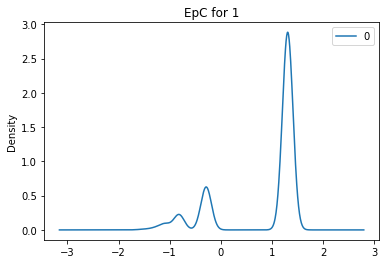

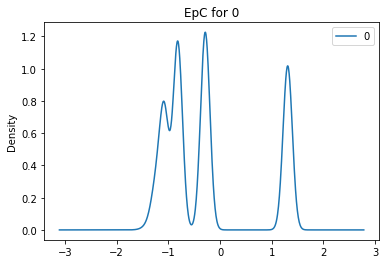

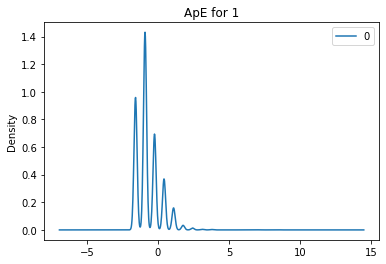

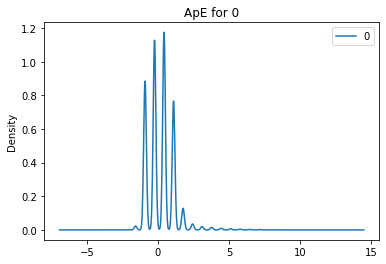

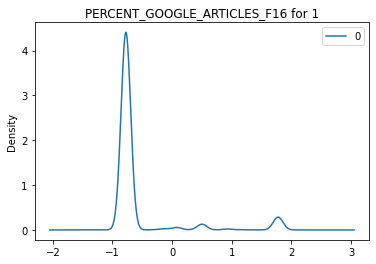

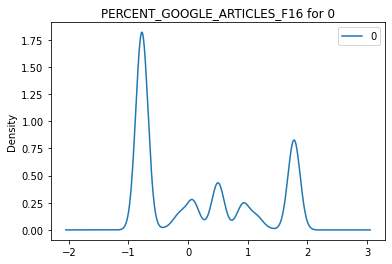

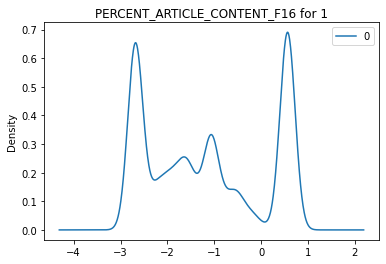

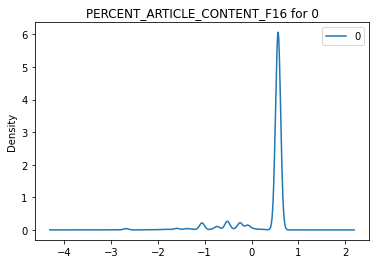

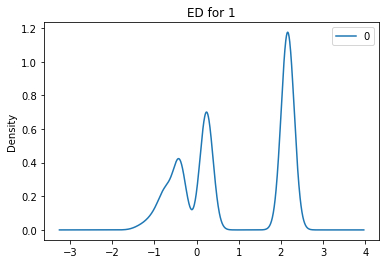

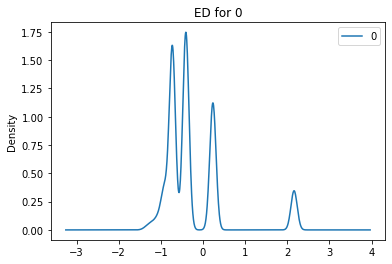

In [20]:
# loop through each feature
for i in range(data.shape[1]):
  # plot the class conditional density
  pd.DataFrame(data[labels == 1,i]).plot.kde(title = f'{features[i]} for 1')
  pd.DataFrame(data[labels == 0,i]).plot.kde(title = f'{features[i]} for 0')
  # print the class conditional mean
  print(data[labels == 1,i].mean())
  print(data[labels == 0,i].mean())
  print()

In [21]:
from sklearn.model_selection import train_test_split

# perform training-validation split on the data
X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2, random_state=82113)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(105884, 5) (26472, 5) (105884,) (26472,)


In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt

# define the weight initializer
init = tf.keras.initializers.GlorotNormal()

# define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=data.shape[1], activation='relu', kernel_initializer=init),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer=init),
    #tf.keras.layers.Dense(10, activation='relu', kernel_initializer=init),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init)
])

# compile the model using the appropriate loss function and optimizer
model.compile(
    loss='binary_crossentropy', 
    optimizer="adam", 
    metrics=['accuracy']
)

# define a training function
def plot_training(model, num_epochs = 25):
  history = model.fit(
    X_train, y_train,
    verbose=0, 
    epochs=num_epochs, 
    batch_size=32,
    validation_data = (X_valid, y_valid),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, 
                                                verbose=0, restore_best_weights=True)]
  )

  _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
  _, test_accuracy = model.evaluate(X_valid, y_valid, verbose=0)
  print('Train: %.2f, Test: %.2f' % (train_accuracy, test_accuracy))

  # plot the training performance metrics
  plt.plot(history.history['accuracy'], label='train_accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Train: 0.92, Test: 0.92


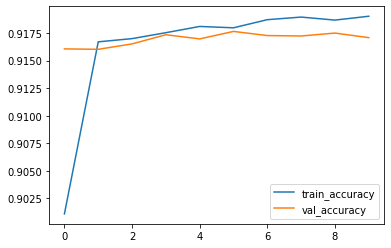

In [23]:
# train the model
plot_training(model, num_epochs=10)

In [24]:
# proportion of training data labeled as 1
sum(y_train)/len(y_train)

0.22909032526160705

828/828 [==============================] - 1s 1ms/step
[[19612   785]
 [ 1410  4665]]


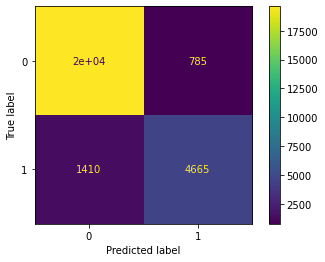

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Print total accuracy and confusion matrix
val_predicts = model.predict(X_valid)
y_pred = 1*(val_predicts >= 0.5)
cm = confusion_matrix(y_valid, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(cm)
disp.plot();
#plt.show()

In [36]:
print('True Postive Rate:', cm[1][1]/(cm[1][1]+cm[1][0]))
print('True Negative Rate:', cm[0][0]/(cm[0][0]+cm[0][1]))

print('False Postive Rate:', cm[0][1]/(cm[0][0]+cm[0][1]))
print('False Negative Rate:', cm[1][0]/(cm[1][1]+cm[1][0]))

True Postive Rate: 0.7679012345679013
True Negative Rate: 0.9615139481296269
False Postive Rate: 0.03848605187037309
False Negative Rate: 0.23209876543209876
